# Binance Data Collection & Preparation

## Objectif
Récupérer et préparer les données de marchés crypto depuis l'API Binance pour appliquer le modèle Almgren-Chriss.

## Pipeline de données
1. **Récupération** : Données OHLCV via l'API publique Binance
2. **Nettoyage** : Détection et traitement des valeurs aberrantes
3. **Feature Engineering** : Calcul des paramètres nécessaires (volatilité, volume, spreads)
4. **Validation** : Vérification de la qualité des données
5. **Export** : Sauvegarde pour utilisation avec le modèle Almgren-Chriss

---

## 1. Setup & Configuration

In [1]:
# Installation des packages nécessaires
!pip install -q python-binance pandas numpy matplotlib seaborn pyarrow requests

print("✅ Packages installés")

✅ Packages installés


In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import requests
import time
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuration graphiques
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 11

# Créer les répertoires de données
Path('data/raw').mkdir(parents=True, exist_ok=True)
Path('data/processed').mkdir(parents=True, exist_ok=True)
Path('results').mkdir(parents=True, exist_ok=True)

print("✅ Configuration terminée")

✅ Configuration terminée


## 2. Récupération des Données Binance

### API Binance - Points clés
- **Endpoint** : `https://api.binance.com/api/v3/klines`
- **Pas d'authentification** nécessaire pour les données publiques
- **Rate limits** : 1200 requêtes/minute pour les endpoints de poids 1
- **Limite de données** : 1000 klines maximum par requête

### Intervalles disponibles
- `1m`, `3m`, `5m`, `15m`, `30m` : Minutes
- `1h`, `2h`, `4h`, `6h`, `8h`, `12h` : Heures
- `1d`, `3d`, `1w`, `1M` : Jours, semaines, mois

In [3]:
class BinanceDataCollector:
    """
    Classe pour récupérer les données OHLCV depuis l'API Binance.
    
    Gère automatiquement:
    - La pagination pour les périodes longues
    - Les rate limits
    - Les erreurs de connexion
    """
    
    def __init__(self, base_url='https://api.binance.com'):
        self.base_url = base_url
        self.session = requests.Session()
        
    def get_klines(self, symbol, interval, start_time=None, end_time=None, limit=1000):
        """
        Récupère les données OHLCV pour un symbole donné.
        
        Parameters:
        -----------
        symbol : str
            Paire de trading (ex: 'BTCUSDT')
        interval : str
            Intervalle de temps (ex: '1m', '5m', '1h', '1d')
        start_time : int or str, optional
            Timestamp de début (ms) ou format 'YYYY-MM-DD'
        end_time : int or str, optional
            Timestamp de fin (ms) ou format 'YYYY-MM-DD'
        limit : int, optional
            Nombre maximum de klines (max 1000)
        
        Returns:
        --------
        pd.DataFrame
            DataFrame avec colonnes: timestamp, open, high, low, close, volume
        """
        
        endpoint = f'{self.base_url}/api/v3/klines'
        
        params = {
            'symbol': symbol,
            'interval': interval,
            'limit': limit
        }
        
        # Convertir les dates string en timestamps
        if isinstance(start_time, str):
            start_time = int(pd.Timestamp(start_time).timestamp() * 1000)
        if isinstance(end_time, str):
            end_time = int(pd.Timestamp(end_time).timestamp() * 1000)
            
        if start_time:
            params['startTime'] = start_time
        if end_time:
            params['endTime'] = end_time
        
        try:
            response = self.session.get(endpoint, params=params, timeout=10)
            response.raise_for_status()
            data = response.json()
            
            # Convertir en DataFrame
            df = pd.DataFrame(data, columns=[
                'timestamp', 'open', 'high', 'low', 'close', 'volume',
                'close_time', 'quote_volume', 'trades', 'taker_buy_base',
                'taker_buy_quote', 'ignore'
            ])
            
            # Sélectionner et convertir les colonnes pertinentes
            df = df[['timestamp', 'open', 'high', 'low', 'close', 'volume', 'trades']].copy()
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            
            for col in ['open', 'high', 'low', 'close', 'volume']:
                df[col] = pd.to_numeric(df[col], errors='coerce')
            df['trades'] = df['trades'].astype(int)
            
            return df
            
        except requests.exceptions.RequestException as e:
            print(f"❌ Erreur lors de la requête: {e}")
            return None
    
    def get_historical_data(self, symbol, interval, start_date, end_date=None):
        """
        Récupère l'historique complet avec pagination automatique.
        
        Parameters:
        -----------
        symbol : str
            Paire de trading
        interval : str
            Intervalle de temps
        start_date : str
            Date de début (format 'YYYY-MM-DD')
        end_date : str, optional
            Date de fin (défaut: aujourd'hui)
        
        Returns:
        --------
        pd.DataFrame
            DataFrame complet avec toutes les données
        """
        
        if end_date is None:
            end_date = datetime.now().strftime('%Y-%m-%d')
        
        start_ts = int(pd.Timestamp(start_date).timestamp() * 1000)
        end_ts = int(pd.Timestamp(end_date).timestamp() * 1000)
        
        all_data = []
        current_ts = start_ts
        
        print(f"📥 Récupération des données {symbol} ({interval})")
        print(f"   Période: {start_date} → {end_date}")
        
        while current_ts < end_ts:
            df = self.get_klines(symbol, interval, start_time=current_ts, end_time=end_ts, limit=1000)
            
            if df is None or len(df) == 0:
                break
            
            all_data.append(df)
            
            # Préparer pour la prochaine itération
            current_ts = int(df['timestamp'].iloc[-1].timestamp() * 1000) + 1
            
            print(f"   Récupéré: {len(df)} lignes, dernier timestamp: {df['timestamp'].iloc[-1]}")
            
            # Respecter les rate limits
            time.sleep(0.1)
        
        if not all_data:
            print("❌ Aucune donnée récupérée")
            return None
        
        # Combiner toutes les données
        full_df = pd.concat(all_data, ignore_index=True)
        full_df = full_df.drop_duplicates(subset=['timestamp']).reset_index(drop=True)
        full_df = full_df.sort_values('timestamp').reset_index(drop=True)
        
        print(f"✅ Total: {len(full_df):,} lignes récupérées")
        
        return full_df
    
    def get_current_price(self, symbol):
        """
        Récupère le prix actuel d'un symbole.
        """
        endpoint = f'{self.base_url}/api/v3/ticker/price'
        params = {'symbol': symbol}
        
        try:
            response = self.session.get(endpoint, params=params, timeout=10)
            response.raise_for_status()
            data = response.json()
            return float(data['price'])
        except:
            return None
    
    def get_24h_stats(self, symbol):
        """
        Récupère les statistiques 24h d'un symbole.
        """
        endpoint = f'{self.base_url}/api/v3/ticker/24hr'
        params = {'symbol': symbol}
        
        try:
            response = self.session.get(endpoint, params=params, timeout=10)
            response.raise_for_status()
            return response.json()
        except:
            return None

print("✅ Classe BinanceDataCollector créée")

✅ Classe BinanceDataCollector créée


### Configuration des symboles à récupérer

In [20]:
# Configuration de la récupération
SYMBOLS = [
    'BTCUSDT',   # Bitcoin
    'ETHUSDT',   # Ethereum
    'SOLUSDT',   # Solana
]

# Intervalle et période
INTERVAL = '1m'  # 5 minutes (390 par jour = 1 trading day)
START_DATE = '2025-11-01'  # 1 mois de données
END_DATE = '2025-12-01'    # Aujourd'hui

print(f"Configuration:")
print(f"  Symboles: {', '.join(SYMBOLS)}")
print(f"  Intervalle: {INTERVAL}")
print(f"  Période: {START_DATE} → {END_DATE}")

Configuration:
  Symboles: BTCUSDT, ETHUSDT, SOLUSDT
  Intervalle: 1m
  Période: 2025-11-01 → 2025-12-01


### Récupération des données

In [21]:
# Instancier le collecteur
collector = BinanceDataCollector()

# Récupérer les données pour chaque symbole
raw_data = {}

for symbol in SYMBOLS:
    print(f"\n{'='*70}")
    df = collector.get_historical_data(symbol, INTERVAL, START_DATE, END_DATE)
    
    if df is not None:
        raw_data[symbol] = df
        
        # Afficher un aperçu
        print(f"\n📊 Aperçu {symbol}:")
        print(f"   Shape: {df.shape}")
        print(f"   Période: {df['timestamp'].min()} → {df['timestamp'].max()}")
        print(f"   Prix moyen: ${df['close'].mean():.2f}")
        print(f"   Volume moyen: {df['volume'].mean():.2f}")
    else:
        print(f"❌ Échec de récupération pour {symbol}")
    
    time.sleep(0.5)  # Pause entre symboles

print(f"\n{'='*70}")
print(f"✅ Récupération terminée: {len(raw_data)} symboles")


📥 Récupération des données BTCUSDT (1m)
   Période: 2025-11-01 → 2025-12-01
   Récupéré: 1000 lignes, dernier timestamp: 2025-11-01 16:39:00
   Récupéré: 1000 lignes, dernier timestamp: 2025-11-02 09:19:00
   Récupéré: 1000 lignes, dernier timestamp: 2025-11-03 01:59:00
   Récupéré: 1000 lignes, dernier timestamp: 2025-11-03 18:39:00
   Récupéré: 1000 lignes, dernier timestamp: 2025-11-04 11:19:00
   Récupéré: 1000 lignes, dernier timestamp: 2025-11-05 03:59:00
   Récupéré: 1000 lignes, dernier timestamp: 2025-11-05 20:39:00
   Récupéré: 1000 lignes, dernier timestamp: 2025-11-06 13:19:00
   Récupéré: 1000 lignes, dernier timestamp: 2025-11-07 05:59:00
   Récupéré: 1000 lignes, dernier timestamp: 2025-11-07 22:39:00
   Récupéré: 1000 lignes, dernier timestamp: 2025-11-08 15:19:00
   Récupéré: 1000 lignes, dernier timestamp: 2025-11-09 07:59:00
   Récupéré: 1000 lignes, dernier timestamp: 2025-11-10 00:39:00
   Récupéré: 1000 lignes, dernier timestamp: 2025-11-10 17:19:00
   Récupéré: 

## 3. Nettoyage et Validation des Données

### Checks de qualité
1. Valeurs manquantes
2. Valeurs aberrantes (outliers)
3. Gaps temporels
4. Cohérence OHLC (Open ≤ High, Low ≤ Close, etc.)

In [22]:
def validate_and_clean_data(df, symbol):
    """
    Valide et nettoie les données OHLCV.
    
    Effectue:
    1. Détection des valeurs manquantes
    2. Vérification de la cohérence OHLC
    3. Détection des outliers de prix et volume
    4. Interpolation des gaps
    
    Returns:
    --------
    pd.DataFrame, dict
        DataFrame nettoyé et dictionnaire de statistiques
    """
    
    print(f"\n🔍 Validation et nettoyage pour {symbol}")
    print(f"   Shape initiale: {df.shape}")
    
    stats = {
        'symbol': symbol,
        'initial_rows': len(df),
    }
    
    df_clean = df.copy()
    
    # 1. Valeurs manquantes
    missing = df_clean.isnull().sum()
    if missing.sum() > 0:
        print(f"   ⚠️ Valeurs manquantes détectées:")
        print(missing[missing > 0])
        df_clean = df_clean.dropna()
    stats['missing_values'] = missing.sum()
    
    # 2. Cohérence OHLC
    inconsistent_ohlc = (
        (df_clean['high'] < df_clean['low']) |
        (df_clean['high'] < df_clean['open']) |
        (df_clean['high'] < df_clean['close']) |
        (df_clean['low'] > df_clean['open']) |
        (df_clean['low'] > df_clean['close'])
    )
    
    n_inconsistent = inconsistent_ohlc.sum()
    if n_inconsistent > 0:
        print(f"   ⚠️ {n_inconsistent} lignes avec OHLC incohérent (supprimées)")
        df_clean = df_clean[~inconsistent_ohlc]
    stats['inconsistent_ohlc'] = n_inconsistent
    
    # 3. Outliers de prix (méthode IQR)
    for col in ['open', 'high', 'low', 'close']:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR  # 3*IQR pour éviter de supprimer trop
        upper_bound = Q3 + 3 * IQR
        
        outliers = (df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)
        n_outliers = outliers.sum()
        
        if n_outliers > 0:
            print(f"   ⚠️ {n_outliers} outliers détectés dans '{col}' (supprimés)")
            df_clean = df_clean[~outliers]
    
    # 4. Outliers de volume (volume = 0 est suspect)
    zero_volume = df_clean['volume'] == 0
    if zero_volume.sum() > 0:
        print(f"   ⚠️ {zero_volume.sum()} lignes avec volume = 0 (supprimées)")
        df_clean = df_clean[~zero_volume]
    stats['zero_volume'] = zero_volume.sum()
    
    # 5. Vérifier les gaps temporels
    df_clean = df_clean.sort_values('timestamp').reset_index(drop=True)
    time_diff = df_clean['timestamp'].diff()
    expected_diff = pd.Timedelta('5min')  # Pour interval='5m'
    
    gaps = time_diff[time_diff > expected_diff * 1.5]  # Tolérance de 50%
    if len(gaps) > 0:
        print(f"   ⚠️ {len(gaps)} gaps temporels détectés")
    stats['time_gaps'] = len(gaps)
    
    # 6. Statistiques finales
    stats['final_rows'] = len(df_clean)
    stats['rows_removed'] = stats['initial_rows'] - stats['final_rows']
    stats['removal_rate'] = stats['rows_removed'] / stats['initial_rows'] * 100
    
    print(f"   ✅ Nettoyage terminé")
    print(f"      Shape finale: {df_clean.shape}")
    print(f"      Lignes supprimées: {stats['rows_removed']} ({stats['removal_rate']:.2f}%)")
    
    return df_clean, stats

print("✅ Fonction de validation créée")

✅ Fonction de validation créée


In [23]:
# Nettoyer les données
clean_data = {}
cleaning_stats = []

for symbol, df in raw_data.items():
    df_clean, stats = validate_and_clean_data(df, symbol)
    clean_data[symbol] = df_clean
    cleaning_stats.append(stats)

# Résumé du nettoyage
df_cleaning_stats = pd.DataFrame(cleaning_stats)
print("\n" + "="*70)
print("📊 Résumé du nettoyage:")
print(df_cleaning_stats[['symbol', 'initial_rows', 'final_rows', 'rows_removed', 'removal_rate']])


🔍 Validation et nettoyage pour BTCUSDT
   Shape initiale: (43201, 7)
   ✅ Nettoyage terminé
      Shape finale: (43201, 7)
      Lignes supprimées: 0 (0.00%)

🔍 Validation et nettoyage pour ETHUSDT
   Shape initiale: (43201, 7)
   ✅ Nettoyage terminé
      Shape finale: (43201, 7)
      Lignes supprimées: 0 (0.00%)

🔍 Validation et nettoyage pour SOLUSDT
   Shape initiale: (43201, 7)
   ✅ Nettoyage terminé
      Shape finale: (43201, 7)
      Lignes supprimées: 0 (0.00%)

📊 Résumé du nettoyage:
    symbol  initial_rows  final_rows  rows_removed  removal_rate
0  BTCUSDT         43201       43201             0           0.0
1  ETHUSDT         43201       43201             0           0.0
2  SOLUSDT         43201       43201             0           0.0


## 4. Visualisation Exploratoire

In [24]:
# Sélectionner un symbole pour visualisation détaillée
FOCUS_SYMBOL = 'BTCUSDT'
df_viz = clean_data[FOCUS_SYMBOL].copy()

print(f"📊 Visualisation pour {FOCUS_SYMBOL}")
print(f"   Période: {df_viz['timestamp'].min()} → {df_viz['timestamp'].max()}")
print(f"   Nombre de points: {len(df_viz):,}")

📊 Visualisation pour BTCUSDT
   Période: 2025-11-01 00:00:00 → 2025-12-01 00:00:00
   Nombre de points: 43,201


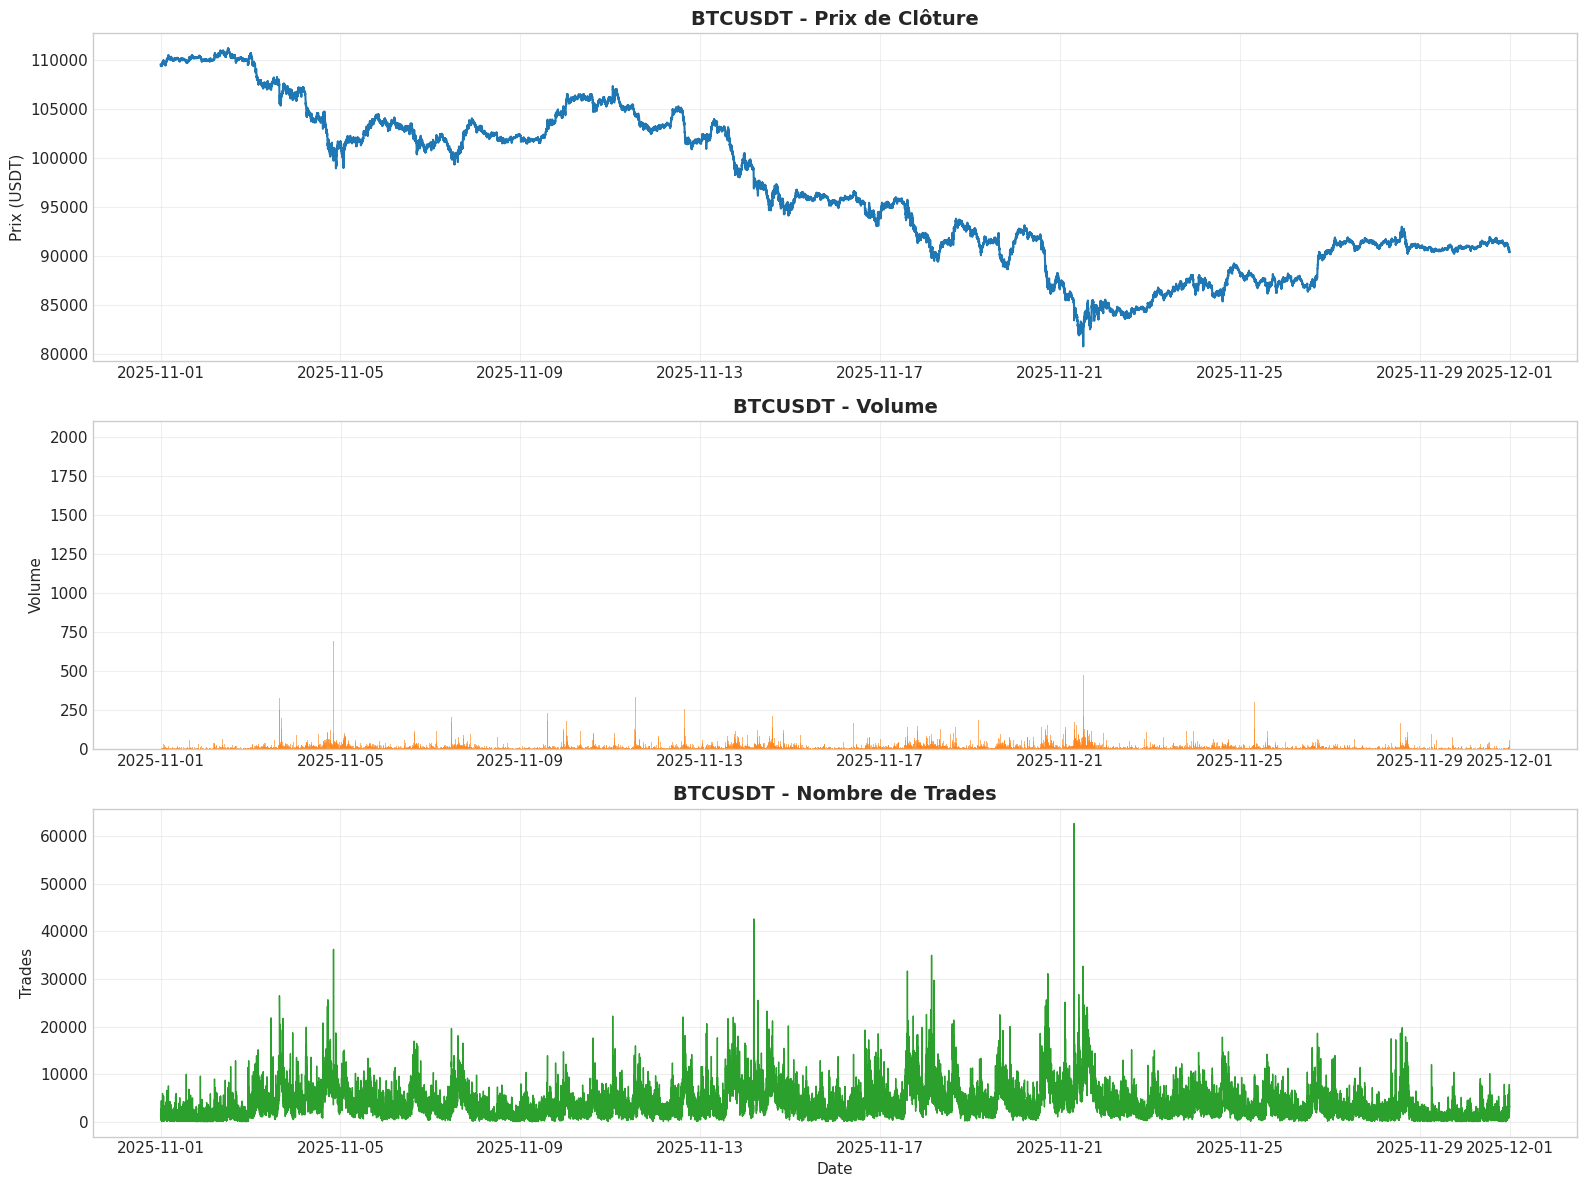

✅ Graphique sauvegardé: results/01_price_volume_overview.png


In [25]:
# 1. Prix et volume
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Prix de clôture
ax = axes[0]
ax.plot(df_viz['timestamp'], df_viz['close'], linewidth=1.5, color='tab:blue')
ax.set_title(f'{FOCUS_SYMBOL} - Prix de Clôture', fontsize=14, fontweight='bold')
ax.set_ylabel('Prix (USDT)')
ax.grid(True, alpha=0.3)

# Volume
ax = axes[1]
ax.bar(df_viz['timestamp'], df_viz['volume'], width=0.002, color='tab:orange', alpha=0.6)
ax.set_title(f'{FOCUS_SYMBOL} - Volume', fontsize=14, fontweight='bold')
ax.set_ylabel('Volume')
ax.grid(True, alpha=0.3)

# Nombre de trades
ax = axes[2]
ax.plot(df_viz['timestamp'], df_viz['trades'], linewidth=1, color='tab:green')
ax.set_title(f'{FOCUS_SYMBOL} - Nombre de Trades', fontsize=14, fontweight='bold')
ax.set_ylabel('Trades')
ax.set_xlabel('Date')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/01_price_volume_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Graphique sauvegardé: results/01_price_volume_overview.png")

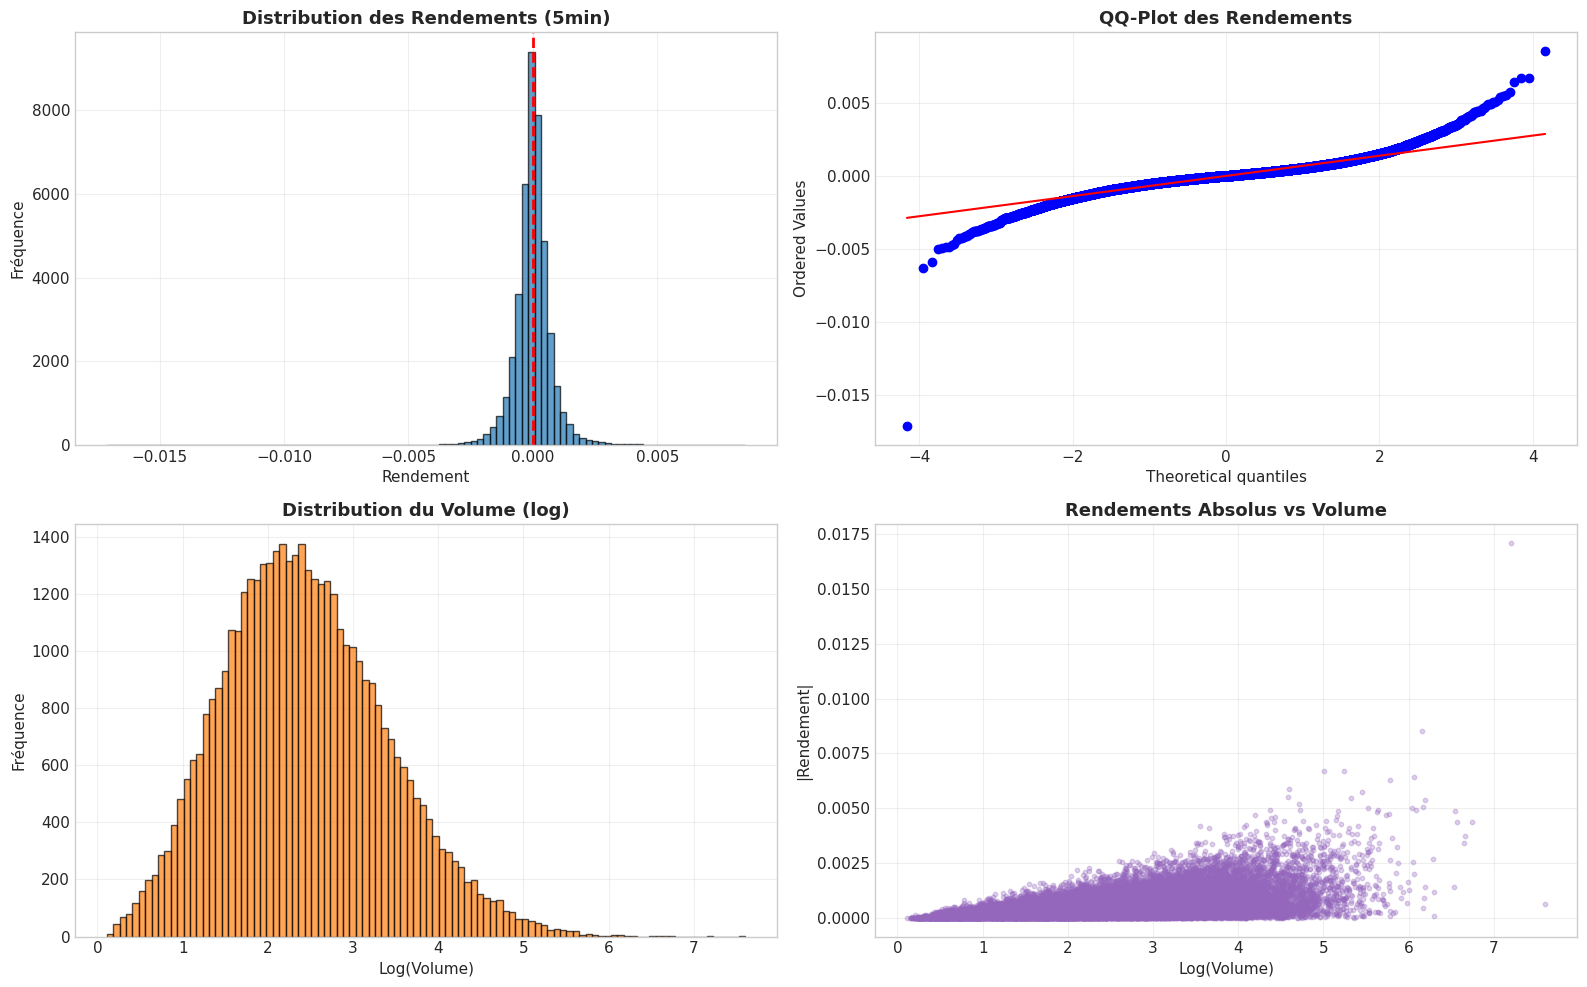

✅ Graphique sauvegardé: results/02_distributions.png


In [26]:
# 2. Distribution des rendements et volume
df_viz['returns'] = df_viz['close'].pct_change()
df_viz['log_volume'] = np.log(df_viz['volume'] + 1)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Distribution des rendements
ax = axes[0, 0]
df_viz['returns'].dropna().hist(bins=100, ax=ax, color='tab:blue', alpha=0.7, edgecolor='black')
ax.axvline(0, color='red', linestyle='--', linewidth=2)
ax.set_title('Distribution des Rendements (5min)', fontsize=13, fontweight='bold')
ax.set_xlabel('Rendement')
ax.set_ylabel('Fréquence')
ax.grid(True, alpha=0.3)

# QQ-plot des rendements
from scipy import stats
ax = axes[0, 1]
stats.probplot(df_viz['returns'].dropna(), dist="norm", plot=ax)
ax.set_title('QQ-Plot des Rendements', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# Distribution du volume
ax = axes[1, 0]
df_viz['log_volume'].hist(bins=100, ax=ax, color='tab:orange', alpha=0.7, edgecolor='black')
ax.set_title('Distribution du Volume (log)', fontsize=13, fontweight='bold')
ax.set_xlabel('Log(Volume)')
ax.set_ylabel('Fréquence')
ax.grid(True, alpha=0.3)

# Relation rendements vs volume
ax = axes[1, 1]
ax.scatter(df_viz['log_volume'], df_viz['returns'].abs(), 
           alpha=0.3, s=10, color='tab:purple')
ax.set_title('Rendements Absolus vs Volume', fontsize=13, fontweight='bold')
ax.set_xlabel('Log(Volume)')
ax.set_ylabel('|Rendement|')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/02_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Graphique sauvegardé: results/02_distributions.png")

In [27]:
# 3. Statistiques descriptives
print("\n📊 Statistiques descriptives des rendements:")
returns_stats = df_viz['returns'].describe()
print(returns_stats)

print("\n📊 Statistiques supplémentaires:")
print(f"   Skewness: {df_viz['returns'].skew():.4f}")
print(f"   Kurtosis: {df_viz['returns'].kurtosis():.4f}")
print(f"   Volatilité (5min): {df_viz['returns'].std():.6f}")
print(f"   Volatilité annualisée: {df_viz['returns'].std() * np.sqrt(252 * 78):.4f}")  # 78 = 390/5


📊 Statistiques descriptives des rendements:
count    43200.000000
mean        -0.000004
std          0.000716
min         -0.017114
25%         -0.000341
50%          0.000000
75%          0.000335
max          0.008532
Name: returns, dtype: float64

📊 Statistiques supplémentaires:
   Skewness: -0.1373
   Kurtosis: 13.2771
   Volatilité (5min): 0.000716
   Volatilité annualisée: 0.1004


## 5. Feature Engineering pour Almgren-Chriss

### Paramètres nécessaires
Pour chaque symbole, calculer:
1. **σ (Volatilité)** : Volatilité annualisée des rendements
2. **V (Volume)** : Volume moyen par jour
3. **S₀ (Prix)** : Prix de référence (médian ou récent)
4. **Spread** : Estimation du spread bid-ask (utile pour ψ)

In [28]:
def compute_market_parameters(df, symbol, interval='5m'):
    """
    Calcule les paramètres de marché nécessaires pour le modèle Almgren-Chriss.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Données OHLCV nettoyées
    symbol : str
        Symbole du ticker
    interval : str
        Intervalle temporel des données
    
    Returns:
    --------
    dict
        Dictionnaire avec les paramètres calculés
    """
    
    print(f"\n📐 Calcul des paramètres pour {symbol}")
    
    # Calculer les rendements
    df['returns'] = df['close'].pct_change()
    
    # 1. VOLATILITÉ
    # Volatilité par intervalle
    vol_interval = df['returns'].std()
    
    # Annualiser la volatilité
    # Pour 5min: 78 intervalles par jour (390 min de trading / 5)
    # Pour 1h: 6.5 intervalles par jour
    if interval == '5m':
        intervals_per_day = 78
    elif interval == '1m':
        intervals_per_day = 390
    elif interval == '1h':
        intervals_per_day = 6.5
    elif interval == '1d':
        intervals_per_day = 1
    else:
        intervals_per_day = 1  # Défaut
    
    vol_daily = vol_interval * np.sqrt(intervals_per_day)
    vol_annual = vol_daily * np.sqrt(252)  # 252 jours de trading
    
    print(f"   σ (volatilité):")
    print(f"      Par intervalle ({interval}): {vol_interval:.6f}")
    print(f"      Journalière: {vol_daily:.6f}")
    print(f"      Annualisée: {vol_annual:.4f}")
    
    # 2. VOLUME
    # Ajouter la date pour grouper par jour
    df['date'] = df['timestamp'].dt.date
    
    # Volume total par jour
    daily_volume = df.groupby('date')['volume'].sum()
    volume_per_day = daily_volume.mean()
    volume_std = daily_volume.std()
    
    print(f"   V (volume moyen par jour): {volume_per_day:,.0f}")
    print(f"      Écart-type: {volume_std:,.0f}")
    print(f"      Min: {daily_volume.min():,.0f}")
    print(f"      Max: {daily_volume.max():,.0f}")
    
    # 3. PRIX
    S0_median = df['close'].median()
    S0_recent = df['close'].iloc[-1]
    S0_mean = df['close'].mean()
    
    print(f"   S₀ (prix):")
    print(f"      Médian: ${S0_median:.2f}")
    print(f"      Récent: ${S0_recent:.2f}")
    print(f"      Moyen: ${S0_mean:.2f}")
    
    # 4. SPREAD ESTIMATION
    # Spread relatif = (High - Low) / Close
    df['spread_pct'] = (df['high'] - df['low']) / df['close'] * 100
    spread_mean = df['spread_pct'].mean()
    spread_median = df['spread_pct'].median()
    
    print(f"   Spread estimé (High-Low):")
    print(f"      Moyen: {spread_mean:.4f}%")
    print(f"      Médian: {spread_median:.4f}%")
    
    # 5. STATISTIQUES ADDITIONNELLES
    # Volume par trade
    df['volume_per_trade'] = df['volume'] / df['trades']
    avg_volume_per_trade = df['volume_per_trade'].mean()
    
    print(f"   Volume moyen par trade: {avg_volume_per_trade:.2f}")
    
    # Créer le dictionnaire de paramètres
    params = {
        'symbol': symbol,
        'interval': interval,
        
        # Volatilité
        'vol_interval': vol_interval,
        'vol_daily': vol_daily,
        'vol_annual': vol_annual,
        
        # Volume
        'volume_per_day': volume_per_day,
        'volume_std': volume_std,
        'volume_min': daily_volume.min(),
        'volume_max': daily_volume.max(),
        
        # Prix
        'S0_median': S0_median,
        'S0_recent': S0_recent,
        'S0_mean': S0_mean,
        
        # Spread
        'spread_pct_mean': spread_mean,
        'spread_pct_median': spread_median,
        'spread_bps_mean': spread_mean * 100,  # En basis points
        
        # Autres
        'avg_volume_per_trade': avg_volume_per_trade,
        'num_trading_days': len(daily_volume),
        'num_intervals': len(df),
    }
    
    return params

print("✅ Fonction de calcul des paramètres créée")

✅ Fonction de calcul des paramètres créée


In [29]:
# Calculer les paramètres pour tous les symboles
market_parameters = []

for symbol, df in clean_data.items():
    params = compute_market_parameters(df, symbol, INTERVAL)
    market_parameters.append(params)

# Créer un DataFrame des paramètres
df_params = pd.DataFrame(market_parameters)

print("\n" + "="*70)
print("📊 Résumé des paramètres de marché:")
print(df_params[['symbol', 'vol_annual', 'volume_per_day', 'S0_recent', 'spread_bps_mean']].to_string(index=False))


📐 Calcul des paramètres pour BTCUSDT
   σ (volatilité):
      Par intervalle (1m): 0.000716
      Journalière: 0.014145
      Annualisée: 0.2245
   V (volume moyen par jour): 25,320
      Écart-type: 14,865
      Min: 60
      Max: 72,256
   S₀ (prix):
      Médian: $95667.80
      Récent: $90408.34
      Moyen: $96573.75
   Spread estimé (High-Low):
      Moyen: 0.0797%
      Médian: 0.0624%
   Volume moyen par trade: 0.00

📐 Calcul des paramètres pour ETHUSDT
   σ (volatilité):
      Par intervalle (1m): 0.001091
      Journalière: 0.021552
      Annualisée: 0.3421
   V (volume moyen par jour): 572,716
      Écart-type: 336,218
      Min: 448
      Max: 1,568,004
   S₀ (prix):
      Médian: $3171.23
      Récent: $2997.57
      Moyen: $3222.25
   Spread estimé (High-Low):
      Moyen: 0.1253%
      Médian: 0.0959%
   Volume moyen par trade: 0.09

📐 Calcul des paramètres pour SOLUSDT
   σ (volatilité):
      Par intervalle (1m): 0.001217
      Journalière: 0.024028
      Annualisée: 

## 6. Visualisation Comparative entre Symboles

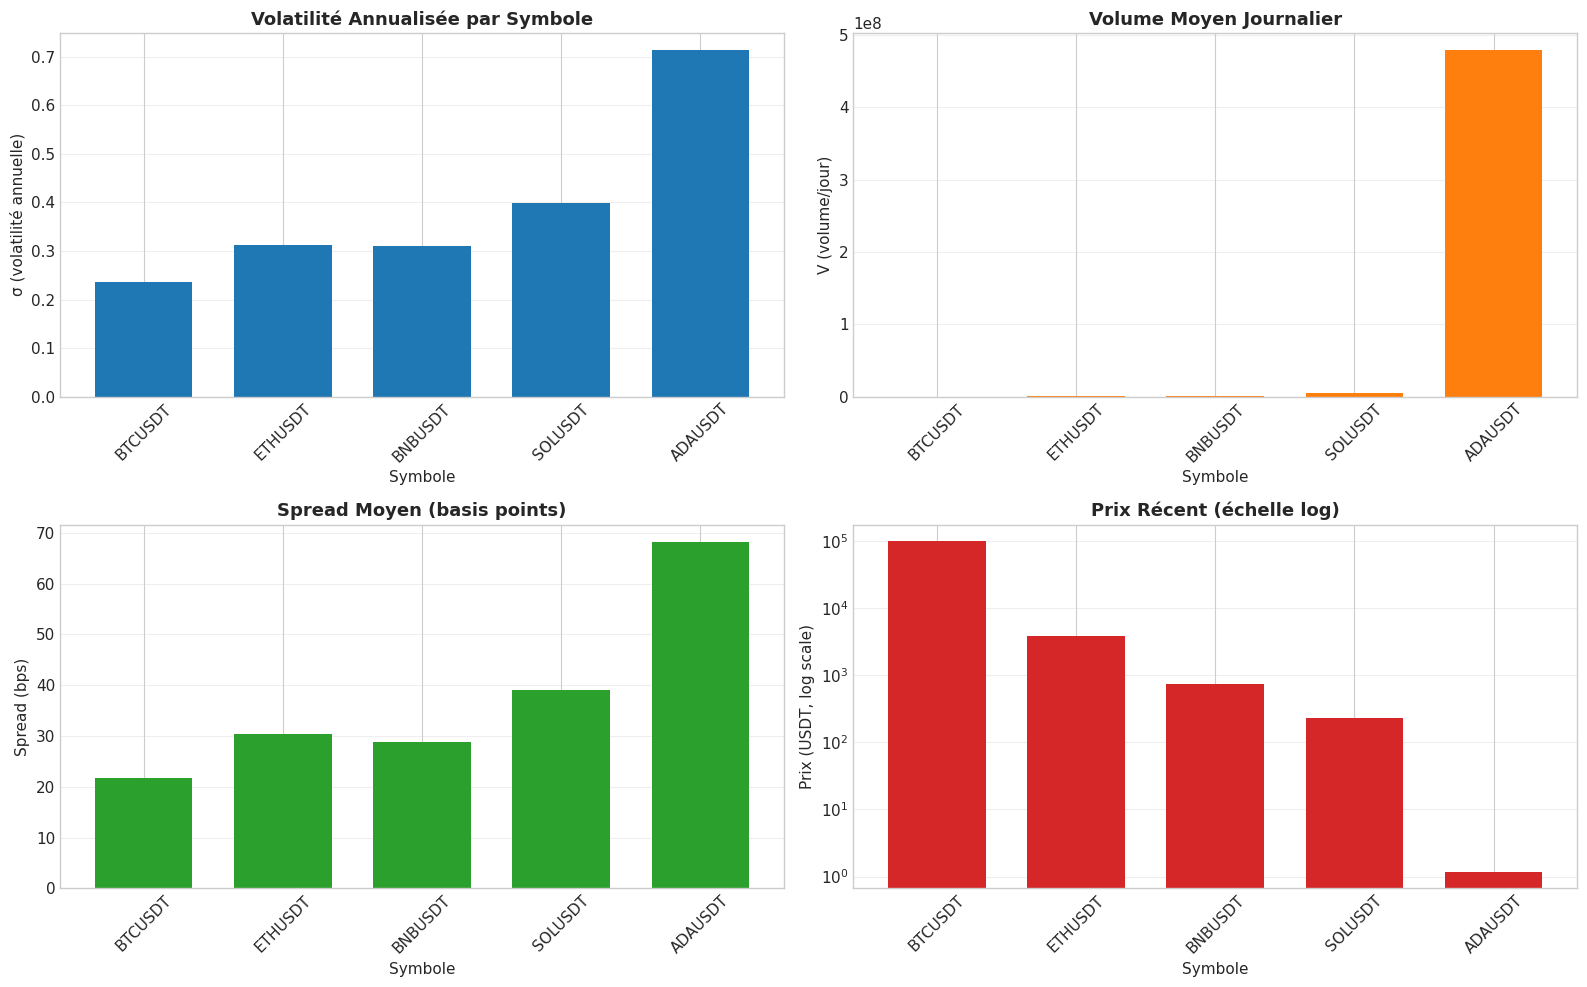

✅ Graphique sauvegardé: results/03_market_parameters_comparison.png


In [14]:
# Comparaison des paramètres
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Volatilité annualisée
ax = axes[0, 0]
df_params.plot(x='symbol', y='vol_annual', kind='bar', ax=ax, 
               color='tab:blue', legend=False, width=0.7)
ax.set_title('Volatilité Annualisée par Symbole', fontsize=13, fontweight='bold')
ax.set_xlabel('Symbole')
ax.set_ylabel('σ (volatilité annuelle)')
ax.grid(True, alpha=0.3, axis='y')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

# 2. Volume moyen journalier
ax = axes[0, 1]
df_params.plot(x='symbol', y='volume_per_day', kind='bar', ax=ax, 
               color='tab:orange', legend=False, width=0.7)
ax.set_title('Volume Moyen Journalier', fontsize=13, fontweight='bold')
ax.set_xlabel('Symbole')
ax.set_ylabel('V (volume/jour)')
ax.grid(True, alpha=0.3, axis='y')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

# 3. Spread moyen (bps)
ax = axes[1, 0]
df_params.plot(x='symbol', y='spread_bps_mean', kind='bar', ax=ax, 
               color='tab:green', legend=False, width=0.7)
ax.set_title('Spread Moyen (basis points)', fontsize=13, fontweight='bold')
ax.set_xlabel('Symbole')
ax.set_ylabel('Spread (bps)')
ax.grid(True, alpha=0.3, axis='y')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

# 4. Prix récent
ax = axes[1, 1]
df_params.plot(x='symbol', y='S0_recent', kind='bar', ax=ax, 
               color='tab:red', legend=False, width=0.7, logy=True)
ax.set_title('Prix Récent (échelle log)', fontsize=13, fontweight='bold')
ax.set_xlabel('Symbole')
ax.set_ylabel('Prix (USDT, log scale)')
ax.grid(True, alpha=0.3, axis='y')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.savefig('results/03_market_parameters_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Graphique sauvegardé: results/03_market_parameters_comparison.png")

## 7. Export des Données

Sauvegarde des données nettoyées et des paramètres pour utilisation avec le modèle Almgren-Chriss.

In [30]:
# 1. Sauvegarder les données brutes nettoyées
for symbol, df in clean_data.items():
    filename = f'data/processed/{symbol}_clean_{INTERVAL}.parquet'
    df.to_parquet(filename, index=False)
    print(f"✅ {filename} sauvegardé ({len(df):,} lignes)")

# 2. Sauvegarder les paramètres de marché
df_params.to_parquet('data/processed/market_parameters.parquet', index=False)
print(f"✅ data/processed/market_parameters.parquet sauvegardé")

# 3. Sauvegarder en CSV pour facilité de lecture
df_params.to_csv('data/processed/market_parameters.csv', index=False)
print(f"✅ data/processed/market_parameters.csv sauvegardé")

# 4. Sauvegarder les statistiques de nettoyage
df_cleaning_stats.to_csv('data/processed/cleaning_statistics.csv', index=False)
print(f"✅ data/processed/cleaning_statistics.csv sauvegardé")

✅ data/processed/BTCUSDT_clean_1m.parquet sauvegardé (43,201 lignes)
✅ data/processed/ETHUSDT_clean_1m.parquet sauvegardé (43,201 lignes)
✅ data/processed/SOLUSDT_clean_1m.parquet sauvegardé (43,201 lignes)
✅ data/processed/market_parameters.parquet sauvegardé
✅ data/processed/market_parameters.csv sauvegardé
✅ data/processed/cleaning_statistics.csv sauvegardé


In [31]:
# 5. Créer un fichier de métadonnées
metadata = {
    'collection_date': datetime.now().isoformat(),
    'symbols': SYMBOLS,
    'interval': INTERVAL,
    'start_date': START_DATE,
    'end_date': END_DATE,
    'total_symbols': len(SYMBOLS),
    'parameters_computed': list(df_params.columns),
    'data_quality': {
        symbol: {
            'rows': int(clean_data[symbol].shape[0]),
            'start': clean_data[symbol]['timestamp'].min().isoformat(),
            'end': clean_data[symbol]['timestamp'].max().isoformat(),
        }
        for symbol in SYMBOLS
    }
}

with open('data/processed/metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("✅ data/processed/metadata.json sauvegardé")

✅ data/processed/metadata.json sauvegardé


## 8. Résumé et Prochaines Étapes

### ✅ Données récupérées et nettoyées

**Fichiers générés:**
- `data/processed/{SYMBOL}_clean_{INTERVAL}.parquet` : Données OHLCV nettoyées
- `data/processed/market_parameters.parquet` : Paramètres de marché (σ, V, S₀, spread)
- `data/processed/metadata.json` : Métadonnées de la collection

### 📊 Paramètres calculés

Pour chaque symbole:
- **σ** : Volatilité annualisée (pour le risque timing)
- **V** : Volume moyen par jour (pour le taux de participation)
- **S₀** : Prix de référence (pour normalisation)
- **Spread** : Estimation pour les coûts proportionnels ψ

### 🎯 Prochaines étapes

1. **Charger les données** dans le notebook Almgren-Chriss:
   ```python
   df_market = pd.read_parquet('data/processed/BTCUSDT_clean_5m.parquet')
   df_params = pd.read_parquet('data/processed/market_parameters.parquet')
   ```

2. **Sélectionner les paramètres** pour un symbole:
   ```python
   params_btc = df_params[df_params['symbol'] == 'BTCUSDT'].iloc[0]
   sigma = params_btc['vol_annual']
   V = params_btc['volume_per_day']
   S0 = params_btc['S0_recent']
   ```

3. **Instancier le modèle** avec les paramètres réels:
   ```python
   model = AlmgrenChrissPowerLaw(
       lambda_risk=lambda_risk,
       sigma=sigma,
       k=k,
       phi=phi,
       eta=eta,
       psi=psi,
       V=V
   )
   ```

4. **Analyser les résultats** et comparer avec TWAP sur données réelles

---

### 💡 Recommandations de calibration

**Paramètres littérature** (à affiner avec données réelles):
- **k** (permanent impact) ≈ 0.0025 - 0.005
- **φ** (exposant) ≈ 0.5 (square root law)
- **η** (cost coefficient) ≈ 0.10 - 0.20
- **ψ** (proportional costs) ≈ spread_bps / 10000
- **λ** (risk aversion) à calibrer selon profil (ex: 1e-6 pour risque modéré)

### 🔬 Analyses complémentaires possibles

- Étudier la saisonnalité intraday du volume
- Analyser la corrélation entre volume et volatilité
- Mesurer l'impact empirique sur ordre book (si données disponibles)
- Backtester la stratégie optimale vs TWAP sur données historiques

In [32]:
# Afficher le résumé final
print("="*70)
print("✅ PIPELINE DE DONNÉES TERMINÉ")
print("="*70)
print(f"\n📊 Données collectées pour {len(SYMBOLS)} symboles:")
for symbol in SYMBOLS:
    n_rows = len(clean_data[symbol])
    print(f"   - {symbol}: {n_rows:,} lignes")

print(f"\n📁 Fichiers sauvegardés dans:")
print(f"   - data/processed/")
print(f"   - results/")

print(f"\n🎯 Prêt pour application du modèle Almgren-Chriss !")

✅ PIPELINE DE DONNÉES TERMINÉ

📊 Données collectées pour 3 symboles:
   - BTCUSDT: 43,201 lignes
   - ETHUSDT: 43,201 lignes
   - SOLUSDT: 43,201 lignes

📁 Fichiers sauvegardés dans:
   - data/processed/
   - results/

🎯 Prêt pour application du modèle Almgren-Chriss !
